In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

In [14]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

In [17]:
print(pdb)
print(files)

data/pentapeptide-impl-solv.pdb
['data/pentapeptide-00-500ns-impl-solv.xtc', 'data/pentapeptide-01-500ns-impl-solv.xtc', 'data/pentapeptide-02-500ns-impl-solv.xtc', 'data/pentapeptide-03-500ns-impl-solv.xtc', 'data/pentapeptide-04-500ns-impl-solv.xtc', 'data/pentapeptide-05-500ns-impl-solv.xtc', 'data/pentapeptide-06-500ns-impl-solv.xtc', 'data/pentapeptide-07-500ns-impl-solv.xtc', 'data/pentapeptide-08-500ns-impl-solv.xtc', 'data/pentapeptide-09-500ns-impl-solv.xtc', 'data/pentapeptide-10-500ns-impl-solv.xtc', 'data/pentapeptide-11-500ns-impl-solv.xtc', 'data/pentapeptide-12-500ns-impl-solv.xtc', 'data/pentapeptide-13-500ns-impl-solv.xtc', 'data/pentapeptide-14-500ns-impl-solv.xtc', 'data/pentapeptide-15-500ns-impl-solv.xtc', 'data/pentapeptide-16-500ns-impl-solv.xtc', 'data/pentapeptide-17-500ns-impl-solv.xtc', 'data/pentapeptide-18-500ns-impl-solv.xtc', 'data/pentapeptide-19-500ns-impl-solv.xtc', 'data/pentapeptide-20-500ns-impl-solv.xtc', 'data/pentapeptide-21-500ns-impl-solv.xtc',

In [18]:
# load backbone torsion angles, backbone heavy atom positions and backbone heavy atom distances
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

In [ ]:
# FEATURE SELECTION

AttributeError: module 'pyemma' has no attribute 'utils'

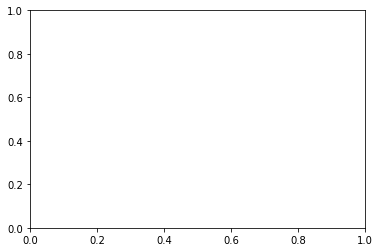

In [21]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [ ]:
# Coordinate transform and discretization

In [22]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

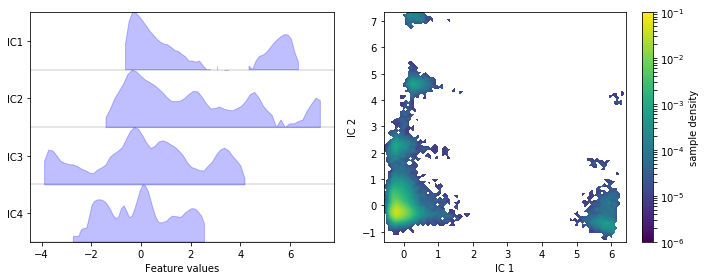

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

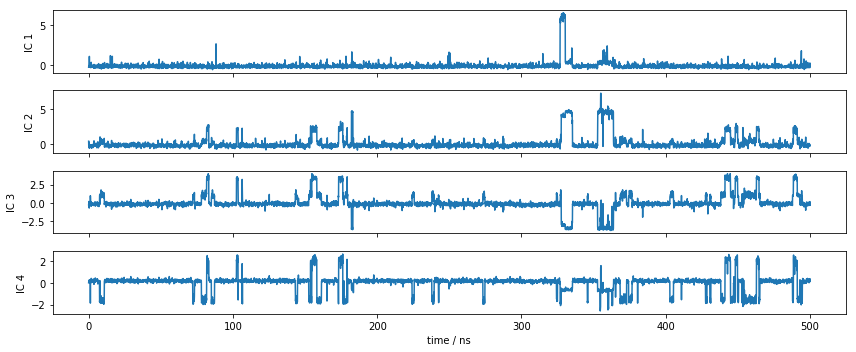

In [24]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

In [ ]:
# Discretization

In [25]:
n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

AttributeError: module 'pyemma.util' has no attribute 'contexts'

In [26]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

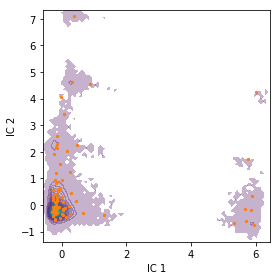

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
# MSM estimation and validation

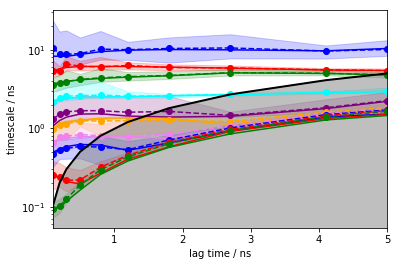

In [28]:
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);

In [29]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00
